/mhome/negassim/misgana_env/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Configuration:
  augment_probability, Value: 1.0
  coarse_dropout_lower, Value: 0.04591006425103699
  coarse_dropout_per_channel, Value: 0.49749350581502183
  coarse_dropout_probability, Value: 0.0
  coarse_dropout_size_percent_lower, Value: 0.0704282853307559
  coarse_dropout_size_percent_upper, Value: 0.15156904567739354
  coarse_dropout_upper, Value: 0.13494551858503537
  elastic_transform_alpha_lower, Value: 0.7747162315031029
  elastic_transform_alpha_upper, Value: 3.2585248728389216
  elastic_transform_probability, Value: 0.0
  elastic_transform_sigma, Value: 0.9618347104328455
  gaussian_noise_probability, Value: 0.0
  gaussian_noise_scale_lower, Value: 0.0924467448034012
  gaussian_noise_scale_upper, Value: 15.583399332989586
  horizontal_flip, Value: 0.5
  pad_crop_lower, Value: -0.125
  pad_crop_probability, Value: 1.0
  pad_crop_upper, Value: 0.125
  rotation_lower, Value: -86
  rotation_probability, Value: 0.0
  rotation_upper, Value: 141
  scale_lower, Value: 0.87150220136

StopIteration: 

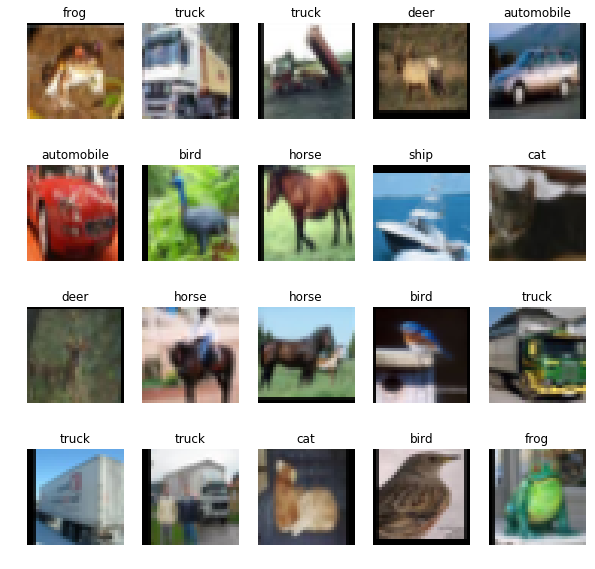

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import ConfigSpace as CS


import keras
from keras.datasets import cifar10
from os.path import abspath, join as path_join
PARENT_DIR =  path_join(os.getcwd(), "..")
sys.path.insert(0, PARENT_DIR)

from autoda.generate_batches import generate_batches
from autoda.data_augmentation import ImageAugmentation
#from autoda.default_augmentation import apply_transform


import imgaug as ia
from imgaug import augmenters as iaa
from imgaug import parameters as iap

ia.seed(1)

labels_dict = {0:"airplane", 1: "automobile", 2: "bird", 3:"cat", 4:"deer", 5:"dog", 6:"frog",
               7:"horse", 8:"ship", 9:"truck"}
sample_config = ImageAugmentation.get_config_space().sample_configuration()

sample_config['augment_probability'] = 1.0                              
sample_config['pad_crop_lower'] = -0.125                                
sample_config['pad_crop_upper'] = 0.125                                 
sample_config['horizontal_flip'] = 0.5                                  
sample_config['pad_crop_probability'] = 1.0                             
   # set other augmeters off                                               
sample_config['scale_probability'] = 0.                                 
sample_config['rotation_probability'] = 0.                              
sample_config['vertical_flip'] = 0.                                     
sample_config['coarse_dropout_probability'] = 0.                                    
sample_config['elastic_transform_probability'] = 0.                     
sample_config['gaussian_noise_probability'] = 0.                        
sample_config["shear_probability"] = 0.    

  
print(sample_config)
(x_train, y_train), _ = cifar10.load_data()
augmenter = ImageAugmentation(sample_config)
aug_batch, y = next(augmenter.apply_transform(x_train, y_train, batch_size=x_train.shape[0]))
#aug_batch, y = next(apply_transform(x_train=x_train, y_train=y_train, batch_size=x_train.shape[0]))

#Visualizing CIFAR 10
n_rows, n_columns = 4, 5
fig, axes1 = plt.subplots(n_rows, n_columns,figsize=(10,10))
i = 0

from itertools import product

axes_iterator = iter(axes1)

indices = product(range(n_rows), range(n_columns))

for image, label in zip(aug_batch, np.reshape(y, (y.shape[0],))):
    label_name = labels_dict[label]
    row, column = next(indices)
    axis = axes1[row][column]
    axis.set_title("{}".format(label_name))
    axis.set_axis_off()
    axis.imshow(image)





In [ ]:

for image, label in zip(x_train[:20], np.reshape(y_train, (y_train.shape[0],))):
    label_name = labels_dict[label]
    row, column = next(indices)
    axis = axes1[row][column]
    axis.set_title("{}".format(label_name))
    axis.set_axis_off()
    axis.imshow(image)


In [ ]:
    from collections import namedtuple
    ParameterRange = namedtuple("ParameterRange", ["lower", "default", "upper"])

    def get_config_space(

            augment_probability=ParameterRange(lower=0, default=0.5, upper=1),
            pad_lower=ParameterRange(lower=0, default=0, upper=0.1),
            pad_upper=ParameterRange(lower=0.1, default=0.1, upper=0.3),
            pad_probability=ParameterRange(lower=0, default=0, upper=1),
            seed=None):

        config_space = CS.ConfigurationSpace(seed)

        hyperparameters = (

            CS.UniformFloatHyperparameter(
                "pad_lower",
                lower=pad_lower.lower,
                default=pad_lower.default,
                upper=pad_lower.upper,
            ),

            CS.UniformFloatHyperparameter(
                "pad_upper",
                lower=pad_upper.lower,
                default=pad_upper.default,
                upper=pad_upper.upper,
            ),

            CS.UniformFloatHyperparameter(
                "pad_probability",
                lower=pad_probability.lower,
                default=pad_probability.default,
                upper=pad_probability.upper,
            ),
            CS.UniformFloatHyperparameter(
                "augment_probability",
                lower=augment_probability.lower,
                default=augment_probability.default,
                upper=augment_probability.upper,
            ),
        )

        config_space.add_hyperparameters(hyperparameters)

        return config_space


In [ ]:
config = get_config_space().sample_configuration()
print(config)
seq = iaa.Sometimes(0.,
        iaa.Sequential([
            iaa.Sometimes(config['pad_probability'],
                          iaa.Pad(
                              percent=(
                                  config['pad_lower'],
                                  config['pad_upper']
                                  )
                              )
                          )
        ], random_order=True
        )
                        )


def apply_transform(x_train, y_train, batch_size=1):

    for batch_x, batch_y in zip(x_train, y_train):
        print(batch_x.shape, batch_y.shape)
                                
        # print("difference", np.sum(batch_x - seq.augment_images(batch_x)))
        yield seq.augment_image(batch_x), batch_y

(x_train, y_train), _ = cifar10.load_data()
aug_x, aug_y = next(apply_transform(x_train, y_train))



In [ ]:
import imgaug as ia
import numpy as np
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

ia.seed(1)

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.
images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(32)],
    dtype=np.uint8
)

seq = iaa.Sequential([
            #iaa.Pad(px=4, keep_size=False),
            #iaa.Crop(px=(0, 4), keep_size=True, sample_independently=True),
             iaa.CropAndPad(percent=(-0.25, .25), keep_size=True),
             #iaa.Fliplr(0.5)
             #iaa.Sometimes(1., iaa.CoarseDropout(p=(0.0, 0.2), size_percent=0.01)),
            #iaa.Affine(rotate=(-30, 30))
            #iaa.Dropout(p=(0.,0.1)
            #iaa.CoarseDropout(p=(0.1, 0.4), size_percent =(0., 0.5), per_channel = 0.1)
           
            #iaa.AdditiveGaussianNoise(scale=(0.01*255, 0.1*255)) 
            #iaa.ElasticTransformation( alpha=2.5, sigma= 1.0)   
    
], random_order=False) # apply augmenters in random order


images_aug = seq.augment_images(images)
print(np.asarray(images_aug).shape)




from itertools import product
n_rows, n_columns = 4, 8
indices = product(range(n_rows), range(n_columns))
fig, axes1 = plt.subplots(n_rows, n_columns,figsize=(10,10))
axes_iterator = iter(axes1)



for image in images_aug:
    row, column = next(indices)
    axis = axes1[row][column]
    axis.imshow(image)

In [ ]:
iaa.Pad?